<a href="https://colab.research.google.com/github/minsu1206/BasicAI/blob/main/hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Default

- Apply Normalization at Dataset

In [1]:
import torch
# import torchvision.datasets as dsets
from torchvision.datasets.mnist import MNIST
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import tqdm
from sklearn.utils import shuffle
import time

In [2]:
data_train = MNIST('./data/mnist',
                   train=True,
                   download=True,
                   transform = transforms.Compose([
                      transforms.Resize((32,32)),
                      transforms.ToTensor(),
                      transforms.Normalize(mean=(0.1307,), std=(0.3801,))]))
data_test = MNIST('./data/mnist',
                 train=False,
                 download=True,
                 transform=transforms.Compose([
                     transforms.Resize((32,32)),
                     transforms.ToTensor(),
                     transforms.Normalize(mean=(0.1307,), std=(0.3801,))
                 ]))

MNIST 셋의 평균과 표준편차를 찾아본 결과, 평균은 0.1307, 표준편차는 0.3801로 나타났다. ToTensor()로 바꾸면 0 ~ 255 범위의 픽셀값들이 0~1로 scaling이 되므로 정규화가 가능하다.

In [3]:
main, throw_up = torch.utils.data.random_split(data_train, [int(len(data_train)*0.05), len(data_train)- int(len(data_train)*0.05)])
data_train_loader = DataLoader(main, batch_size=256, shuffle=True, num_workers=8)
data_test_loader = DataLoader(data_test, batch_size=1024, num_workers=8)

In [4]:
training_epochs = 50
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print(device)

cpu


Utils

In [5]:
def train(model, filtering=False, training_epochs=50):
    criterion = nn.CrossEntropyLoss().to(device)
    if filter == True:
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = []
    start = time.perf_counter()
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = len(data_train_loader)
        for i,(X, Y) in enumerate(data_train_loader):        
            optimizer.zero_grad()
            y_hat = model(X.to(device))
            cost = criterion(y_hat, Y.to(device))
            cost.backward()
            optimizer.step()
            avg_cost += cost / total_batch
        history.append(float(avg_cost))
        if epoch % 5 == 0:
            print('Epoch:', '%04d' % (epoch), 'cost=', '{:.9f}'.format(avg_cost))
    end = time.perf_counter()
    print('Training Done')
    print(end - start)
    return model, history

In [6]:
def check_freezing(model):
    for i, param in enumerate(model.parameters()):
        if param.requires_grad == True:
            print(i, 'Not Freeze')
        else:
            print(i, 'Freezed')

In [7]:
def test(model):
    criterion = nn.CrossEntropyLoss().to(device)
    model.eval()
    total_correct = 0
    avg_loss = 0
    for i, (X, Y) in enumerate(data_test_loader):
        output = model(X.to(device))
        avg_loss += criterion(output, Y.to(device)).sum()
        pred = output.detach().max(1)[1]
        total_correct += pred.eq(Y.to(device).view_as(pred)).sum()
    avg_loss /= len(data_test)
    print('Test Average Cost: %f, Accuracy: %f' % (avg_loss.detach().cpu().item(), float(total_correct)/len(data_test)))

# 1. Original LeNet5

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1,6,(5,5), padding=0).to(device),
                                   nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv2d(6,16,(5,5), padding=0).to(device),
                                   nn.ReLU())
        self.fc1 = nn.Sequential(nn.Linear(16*5*5, 120).to(device), nn.ReLU())
        self.fc2 = nn.Sequential(nn.Linear(120,84).to(device), nn.ReLU())
        self.fc3 = nn.Linear(84, 10).to(device)
        
    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), (2,2)).to(device)
        x = F.max_pool2d(self.conv2(x), (2,2)).to(device)
        x = x.view(-1, self.num_flat_features(x)).to(device)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [9]:
original = LeNet()

In [10]:
summary(original, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
              ReLU-4           [-1, 16, 10, 10]               0
            Linear-5                  [-1, 120]          48,120
              ReLU-6                  [-1, 120]               0
            Linear-7                   [-1, 84]          10,164
              ReLU-8                   [-1, 84]               0
            Linear-9                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.24
Estimated Total Size (MB): 0.34
---------------------------------------------

In [11]:
original, history_raw = train(original)

Epoch: 0000 cost= 2.178341389
Epoch: 0005 cost= 0.352550864
Epoch: 0010 cost= 0.207792833
Epoch: 0015 cost= 0.133681729
Epoch: 0020 cost= 0.082961805
Epoch: 0025 cost= 0.057649024
Epoch: 0030 cost= 0.047499448
Epoch: 0035 cost= 0.026082631
Epoch: 0040 cost= 0.014490498
Epoch: 0045 cost= 0.010873962
Training Done
81.53149316200052


In [12]:
test(original)

Test Average Cost: 0.000127, Accuracy: 0.967400


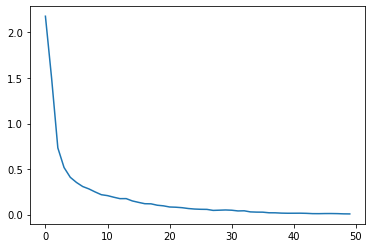

In [13]:
plt.plot(history_raw)

# 2. BatchNormalization

In [14]:
freeze = 0
for param in original.parameters():
    if freeze < 2:
        param.requires_grad = True ## if True, unfreeze
    else:
        param.requires_grad = False
    freeze += 1

In [15]:
check_freezing(original)

0 Not Freeze
1 Not Freeze
2 Freezed
3 Freezed
4 Freezed
5 Freezed
6 Freezed
7 Freezed
8 Freezed
9 Freezed


In [16]:
original.conv1 = nn.Sequential(
    nn.Conv2d(1,6,(5,5), padding=0).to(device),
    nn.ReLU(),
    nn.BatchNorm2d(6)
)

In [17]:
original.conv2 = nn.Sequential(
    nn.Conv2d(6,16,(5,5), padding=0).to(device),
    nn.ReLU(),
    nn.BatchNorm2d(16)
)

In [18]:
summary(original, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
       BatchNorm2d-6           [-1, 16, 10, 10]              32
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             ReLU-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 61,750
Trainable params: 2,616
Non-trainable params: 59,134
----------------------------------------------------------------
Input size (MB): 0.00
Forwar

In [19]:
check_freezing(original)

0 Not Freeze
1 Not Freeze
2 Not Freeze
3 Not Freeze
4 Not Freeze
5 Not Freeze
6 Not Freeze
7 Not Freeze
8 Freezed
9 Freezed
10 Freezed
11 Freezed
12 Freezed
13 Freezed


In [20]:
second, history_2 = train(original, filtering=True)

Epoch: 0000 cost= 1.716675401
Epoch: 0005 cost= 0.206496418
Epoch: 0010 cost= 0.138527289
Epoch: 0015 cost= 0.107092611
Epoch: 0020 cost= 0.085759751
Epoch: 0025 cost= 0.071466669
Epoch: 0030 cost= 0.060241863
Epoch: 0035 cost= 0.050531100
Epoch: 0040 cost= 0.043676861
Epoch: 0045 cost= 0.037857112
Training Done
97.42893017799997


In [21]:
test(second)

Test Average Cost: 0.000105, Accuracy: 0.969800


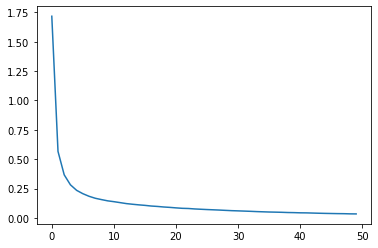

In [61]:
plt.plot(history_2)

# 3. Weight Initialization

In [23]:
num = 0
for m in second.modules():
    if isinstance(m, nn.Conv2d):
        print(num, 'True')
        torch.nn.init.xavier_uniform(m.weight)

0 True
0 True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  """


In [24]:
third, history_3 = train(second, filtering=True)

Epoch: 0000 cost= 2.006789923
Epoch: 0005 cost= 0.144374773
Epoch: 0010 cost= 0.089670986
Epoch: 0015 cost= 0.060140464
Epoch: 0020 cost= 0.041558333
Epoch: 0025 cost= 0.028813455
Epoch: 0030 cost= 0.019936778
Epoch: 0035 cost= 0.014111835
Epoch: 0040 cost= 0.009974269
Epoch: 0045 cost= 0.007654566
Training Done
92.82957441999952


In [25]:
test(third)

Test Average Cost: 0.000161, Accuracy: 0.963200


In [26]:
num = 0
for m in second.modules():
    if isinstance(m, nn.Conv2d):
        print(num, 'True')
        torch.nn.init.kaiming_normal_(m.weight)

0 True
0 True


In [27]:
third_k, history_3_k = train(second, filtering=True)

Epoch: 0000 cost= 24.957721710
Epoch: 0005 cost= 1.150804162
Epoch: 0010 cost= 0.601957440
Epoch: 0015 cost= 0.416473925
Epoch: 0020 cost= 0.303829014
Epoch: 0025 cost= 0.228510052
Epoch: 0030 cost= 0.184304878
Epoch: 0035 cost= 0.146801844
Epoch: 0040 cost= 0.118933819
Epoch: 0045 cost= 0.096105196
Training Done
93.20175057100005


In [28]:
test(third_k)

Test Average Cost: 0.000528, Accuracy: 0.936900


# Dropout

In [52]:
c = 1
for param, m in zip(second.parameters(), second.modules()):
    if c < 7:
    # if isinstance(m, nn.Conv2d):
        param.requires_grad = False
        # print('conv')
    # if isinstance(m, nn.BatchNorm2d):
        # param.requires_grad = False
    else:
        param.requires_grad = True
    c += 1

In [53]:
check_freezing(second)

0 Freezed
1 Freezed
2 Freezed
3 Freezed
4 Freezed
5 Freezed
6 Not Freeze
7 Not Freeze
8 Not Freeze
9 Not Freeze
10 Not Freeze
11 Not Freeze
12 Not Freeze
13 Not Freeze


In [54]:
second.conv1.requires_grad = False
second.conv2.requires_grad = False
second.fc1.requires_grad = True
second.fc1 = nn.Sequential(nn.Linear(400, 120).to(device), 
                           nn.ReLU(),
                           nn.Dropout(0.2)
)
second.fc2.requires_grad = True
second.fc2 = nn.Sequential(nn.Linear(120, 84).to(device), 
                           nn.ReLU(),
                           nn.Dropout(0.2)
)
second.fc3.requires_grad = True

In [55]:
summary(second, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
       BatchNorm2d-6           [-1, 16, 10, 10]              32
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
           Dropout-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
          Dropout-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
             ReLU-14                   

In [56]:
check_freezing(second)

0 Freezed
1 Freezed
2 Freezed
3 Freezed
4 Freezed
5 Freezed
6 Not Freeze
7 Not Freeze
8 Not Freeze
9 Not Freeze
10 Not Freeze
11 Not Freeze
12 Not Freeze
13 Not Freeze


In [57]:
print(second)

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (fc3): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
)


In [58]:
last, history_4 = train(second, filtering=True)

Epoch: 0000 cost= 2.027822018
Epoch: 0005 cost= 0.656907439
Epoch: 0010 cost= 0.497851163
Epoch: 0015 cost= 0.272023678
Epoch: 0020 cost= 0.030131064
Epoch: 0025 cost= 0.019843854
Epoch: 0030 cost= 0.010542480
Epoch: 0035 cost= 0.010263963
Epoch: 0040 cost= 0.008451282
Epoch: 0045 cost= 0.009846248
Training Done
67.87057021700002


In [59]:
test(last)

Test Average Cost: 0.000149, Accuracy: 0.972800


In [60]:
summary(last, input_size=(1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
              ReLU-2            [-1, 6, 28, 28]               0
       BatchNorm2d-3            [-1, 6, 28, 28]              12
            Conv2d-4           [-1, 16, 10, 10]           2,416
              ReLU-5           [-1, 16, 10, 10]               0
       BatchNorm2d-6           [-1, 16, 10, 10]              32
            Linear-7                  [-1, 120]          48,120
              ReLU-8                  [-1, 120]               0
           Dropout-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
          Dropout-12                   [-1, 84]               0
           Linear-13                   [-1, 10]             850
             ReLU-14                   

# Visualization -> Comparison

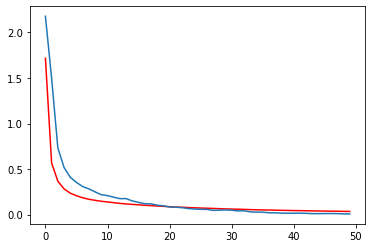

In [64]:
plt.plot(history_2, color='red') # Batch
plt.plot(history_raw)
plt.show()

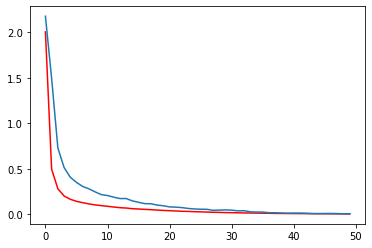

In [63]:
plt.plot(history_3, color='red')  # Xavier
plt.plot(history_raw)
plt.show()

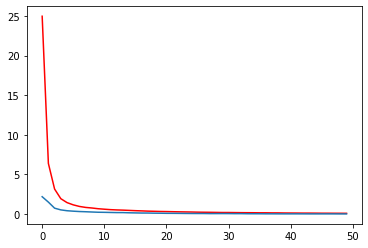

In [65]:
plt.plot(history_3_k, color='red')
plt.plot(history_raw)
plt.show()

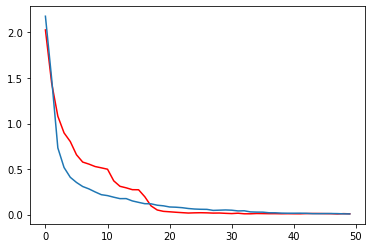

In [66]:
plt.plot(history_4, color='red') # Dropout + Batch
plt.plot(history_raw)
plt.show()